# Toxic Comment Classification - Notebook Overview


Introduction:
This notebook demonstrates how to process, explore, and analyze the "Civil Comments" dataset for toxic comment classification using Python, NLP libraries, and visualization tools. It includes preprocessing, statistical analysis, and initial visual exploration.

## Table of Contents
1. [Importing Libraries](#1.Importing-Libraries)
2. [Loading the Dataset](#2.Loading-the-Dataset)
3. [Understanding the Dataset](#3.Understanding-the-Dataset)
4. [Text Preprocessing](#4.Text-Preprocessing)
5. [Label Distribution Analysis](#5.Label-Distribution-Analysis)
6. [Visualizations](#6.Visualizations)
7. [Label Correlation](#7.Label-Correlation)



## 1. Importing Libraries
We begin by importing essential libraries:

Numpy and Pandas for data handling.

Matplotlib and Seaborn for data visualization.

NLTK for natural language processing, including stopwords removal.

TensorFlow/Keras for future modeling.

Scikit-learn for model evaluation utilities.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix 


nltk.download('stopwords')  # Download stopwords used for text cleaning

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tamer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Loading the Dataset
We load the dataset from HuggingFace's datasets library and inspect its structure.

In [7]:
# Load civil_comments dataset
dataset = load_dataset("google/civil_comments")
print(dataset['train'][0])

{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


The dataset contains the following columns:

In [8]:
print(dataset['train'].column_names)

['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']


### Show first 5 lines of data

In [18]:
df = pd.DataFrame(dataset['train'])
df.head() 

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


## 3. Data Cleaning and Preprocessing
We clean the text by removing digits, punctuation, and stopwords.

In [10]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning
df = pd.DataFrame(dataset['train'])
df['text'] = df['text'].map(lambda x: clean_text(x))

## 4. Exploratory Data Analysis (EDA)

### A. Label Distribution
We calculate how often each type of toxicity appears.

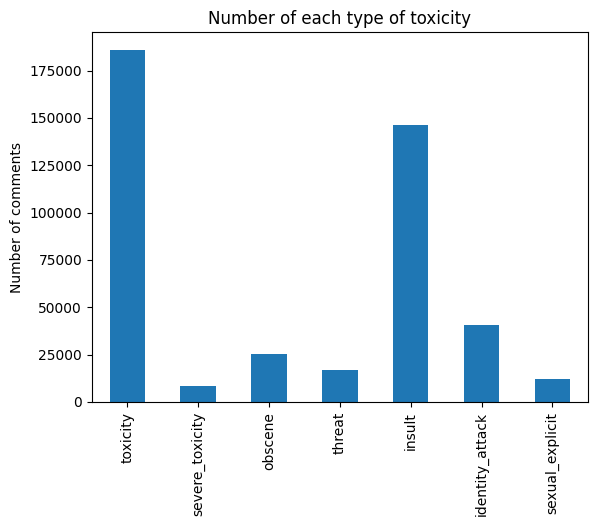

In [11]:
label_counts = df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].sum()
label_counts.plot(kind='bar', title='Number of each type of toxicity', ylabel='Number of comments')
plt.show()

Chart Explanation: This bar chart illustrates the frequency of each type of toxic comment in the dataset.

### B. Multi-label Comments
We identify how many comments contain more than one label.

In [12]:
df['num_labels'] = df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].sum(axis=1)
multi_label_comments = df[df['num_labels'] > 1]
print(f"Multi-label comments count: {len(multi_label_comments)}")

Multi-label comments count: 160669


### C. Toxic vs Non-toxic Comments

In [13]:
toxic_comments = df[df['num_labels'] >= 1]
print(f"Total toxic comments: {len(toxic_comments)}")

Total toxic comments: 168148


Insight: Helps understand class imbalance in the dataset.

### D. Label Frequency and Proportion

In [15]:
label_counts = df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].sum().sort_values(ascending=False).round(2)
label_ratios = (label_counts / len(df)) * 100

summary = pd.DataFrame({
    'Total': label_counts,
    'Ratio (%)': label_ratios.round(2)
})
print(summary)

                     Total  Ratio (%)
toxicity         185933.24      10.30
insult           146470.46       8.12
identity_attack   40854.61       2.26
obscene           25046.61       1.39
threat            16805.67       0.93
sexual_explicit   11922.95       0.66
severe_toxicity    8270.11       0.46


Table Explanation: Summarizes how prevalent each type of toxicity is, both in raw counts and percentages.

### E. Correlation Analysis

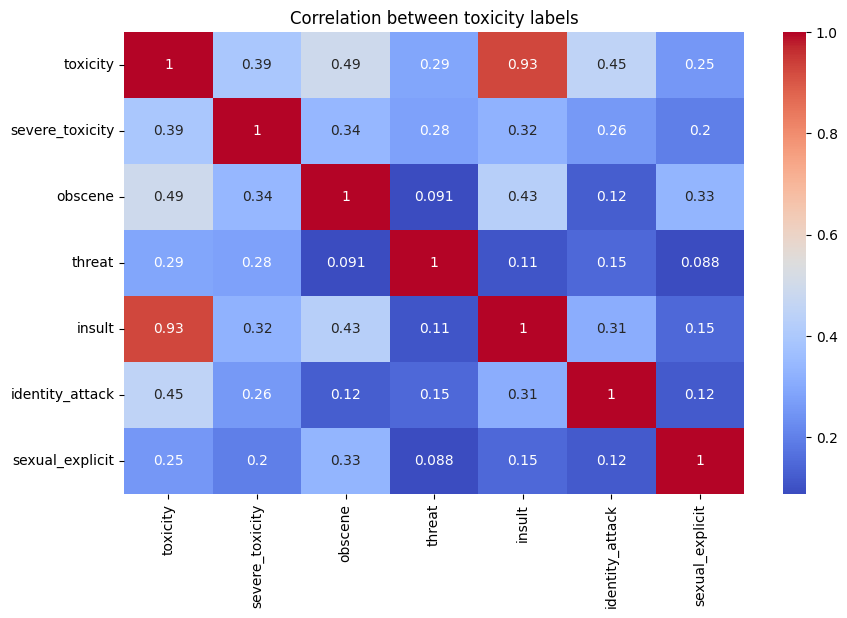

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between toxicity labels')
plt.show()

This heatmap illustrates the correlation between different toxic comment labels. Notably, there is a very strong correlation (0.93) between toxicity and insult, indicating that comments labeled as toxic are highly likely to also be insulting. Such strong correlations can help guide model design by highlighting which labels frequently co-occur.



## 5. An Evaluation of Numerical Text Representations in Natural Language Processing
In natural language processing, the choice of text representation can significantly affect model performance. Traditional methods like Bag of Words (BoW) and TF-IDF (Term Frequency-Inverse Document Frequency) represent text as sparse vectors based on word counts or their weighted importance. While BoW captures simple frequency information, it ignores the context and semantics of words, often resulting in high-dimensional vectors. TF-IDF improves upon this by reducing the influence of common words and emphasizing rarer, more informative terms. However, both methods fail to capture the deeper relationships between words, such as similarity in meaning or syntactic roles.

To overcome these limitations, I chose to use word embeddings (such as Word2Vec or GloVe) as the primary text representation in my project. Embeddings map words to dense, low-dimensional vectors that preserve semantic relationships based on their usage in large corpora. This allows models to better understand context, handle synonyms, and generalize across similar patterns in language. For tasks involving nuanced understanding of text, such as multi-label toxic comment classification, embeddings provide a more powerful and context-aware foundation than BoW or TF-IDF.

This decision aligns with the findings of Mikolov et al. (2013), who demonstrated that word embeddings significantly improve the performance of NLP models by capturing linguistic regularities and semantic relationships in vector space.

Reference: Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781). *arXiv preprint arXiv:1301.3781*.


## 6. Splitting data into training and testing:

In [19]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].values,  # text
    df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].values,  # labels 
    test_size=0.2,  
    random_state=42  
)

print(f"Train texts: {len(train_texts)}")
print(f"Test texts: {len(test_texts)}")

Train texts: 1443899
Test texts: 360975


## 7.  Text Tokenization and Preprocessing for Embedding

### 1. Tokenizing Text Data Using the Tokenizer
To convert the text data into a format that a neural network can understand, we first need to tokenize it. Tokenization is the process of splitting a sentence or document into individual words or sub-words. The Tokenizer class in Keras is used for this purpose.

In [20]:
tokenizer = Tokenizer()  
tokenizer.fit_on_texts(train_texts)  # Train the tokenizer using the training texts


Explanation: The fit_on_texts() method builds the word index based on the frequency of each word in the training dataset. This creates a mapping of words to integers.

### 2. Converting Texts to Sequences of Tokens
Once the tokenizer is trained, we can convert the raw text into a sequence of integers, where each word is replaced by its corresponding token (integer) in the vocabulary.

In [21]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

Explanation: The texts_to_sequences() method transforms the text data into a sequence of integers. Each word in the text is mapped to its integer index from the tokenizer's vocabulary. This step converts text into a form suitable for input into machine learning models.

### 3. Padding Sequences for Consistency
Text data sequences are of varying lengths, so it is necessary to standardize their lengths before passing them into the model. Padding ensures that all sequences are the same length, making it compatible for batch processing.

In [22]:
max_len = 100  # This can be adjusted 
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')

Explanation: The pad_sequences() method ensures that all sequences have the same length by adding padding tokens (usually zeros) to the end of shorter sequences. The maxlen parameter defines the target length, and any sequence longer than this will be truncated.

By following these steps, we ensure that our text data is appropriately tokenized, converted to numeric format, and padded to a uniform length. This allows the model to process the data effectively, making it suitable for embedding-based models, which can then learn to capture semantic relationships between words.


## 8. Building a Bidirectional LSTM Model for Multi-label Text Classification

In [ ]:
# 1. Model Initialization
model = Sequential()

# 2. Embedding Layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=100,  
                    input_length=max_len))

# 3. First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=True))) 

# 4. Dropout Layer if necessary 
# model.add(Dropout(0.5))

# 5. Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32))) 

# 6. Dense Output Layer
model.add(Dense(7, activation='sigmoid')) 

# 7. Model Compilation
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 8. Model Training
history = model.fit(
    train_sequences,
    train_labels,  
    validation_data=(test_sequences, test_labels),
    epochs=5,
    batch_size=32
)


Epoch 1/5
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 18196s 403ms/step - accuracy: 0.9450 - loss: 0.1044 - val_accuracy: 0.8723 - val_loss: 0.0935
Epoch 2/5
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 18162s 402ms/step - accuracy: 0.9331 - loss: 0.0905 - val_accuracy: 0.9563 - val_loss: 0.0936
Epoch 3/5
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 18600s 412ms/step - accuracy: 0.9248 - loss: 0.0875 - val_accuracy: 0.9507 - val_loss: 0.0941
Epoch 4/5
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 18265s 405ms/step - accuracy: 0.9183 - loss: 0.0848 - val_accuracy: 0.9279 - val_loss: 0.0957
Epoch 5/5
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 18334s 406ms/step - accuracy: 0.9142 - loss: 0.0826 - val_accuracy: 0.9280 - val_loss: 0.0971


Explanation:
1. This initializes a sequential model using Keras, which allows we to stack layers one after the other in a linear manner.
2. This layer transforms each word into a dense numeric vector of length 100. These embeddings are learned during training.

    input_dim: The vocabulary size (+1 for padding).

    output_dim: Dimension of the embedding vectors.

    input_length: Maximum sequence length (after padding).
3. This LSTM layer reads the text in both forward and backward directions. return_sequences=True is used because we will add another LSTM layer next, and we need the full sequence as input.
4. Dropout helps prevent overfitting by randomly disabling 50% of the neurons during training, which forces the model to learn more robust features.
5. Another LSTM layer to further process the sequence from the previous layer. This one outputs the final summary of the sequence, as return_sequences is not used here.
6. The final output layer predicts one of 7 classes using the softmax activation function.
7. Optimizer: Adam is widely used and adapts the learning rate automatically.

    Loss Function:
    Use categorical_crossentropy for multi-class (single-label) classification.
    Use binary_crossentropy for multi-label classification (recommended for toxic comment tasks).
8. This step trains the Bidirectional LSTM model using the training data. The fit() function feeds the padded sequences and their corresponding labels into the model for multiple iterations (epochs).

    train_sequences: Input sequences (padded) used for training.
    
    train_labels: The multi-label classification targets.
    
    validation_data: A tuple containing validation inputs and labels. This allows the model to evaluate its performance on unseen data after each epoch.
    
    epochs=5: The model will go through the entire training dataset 5 times. You can increase this for better accuracy if the model is not overfitting.
    
    batch_size=32: The number of samples the model will process before updating its weights. A batch size of 32 is commonly used for balance between performance and memory usage.
    
    The history object stores details about the training process, such as loss and accuracy across epochs. This can be used later for visualizing training performance.


## 9. Saving the Trained Model

In [30]:
# Save the entire model to an HDF5 file
model.save('toxicity_model.h5')
print("Model saved to 'toxicity_model.h5'.")

# Optionally, save the training history for future analysis
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved to 'training_history.pkl'.")

Model saved to 'toxicity_model.h5'.
Training history saved to 'training_history.pkl'.


Explanation:
model.save('toxicity_model.h5')
Saves the full model, including its architecture, weights, and optimizer state.
We can load it later using load_model() from Keras without retraining.

pickle.dump(history.history, f)
Saves the training metrics (e.g., accuracy and loss per epoch) so we can later plot graphs or compare multiple models.


In [34]:
model.save('my_model.keras')
print("Model saved to 'toxicity_model.keras'.")

Model saved to 'toxicity_model.h5'.


## 10. Model Evaluation and Performance Visualization

### 1: Evaluate the model on test data
Get the final accuracy and loss on the test set after training

In [31]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

11281/11281 ━━━━━━━━━━━━━━━━━━━━ 505s 45ms/step - accuracy: 0.9285 - loss: 0.0966
Test Accuracy: 0.9280
Test Loss: 0.0971


### 2: Plot training & validation accuracy over epochs

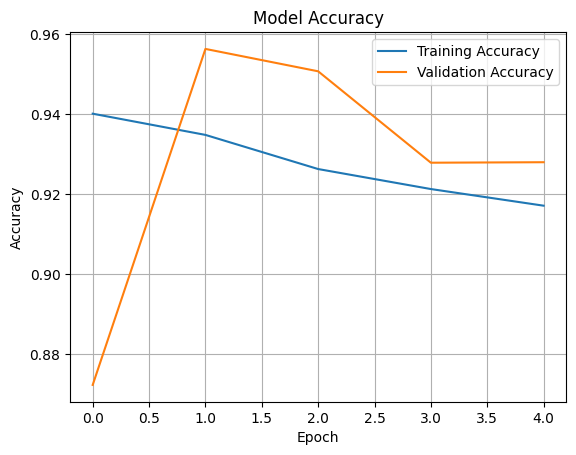

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 3: Plot training & validation loss over epochs

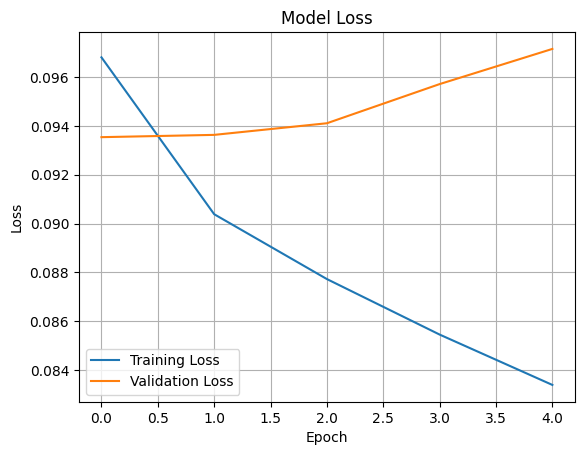

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Performance evaluation

11281/11281 ━━━━━━━━━━━━━━━━━━━━ 468s 41ms/step
                 precision    recall  f1-score   support

       toxicity       0.79      0.51      0.62     29078
severe_toxicity       0.00      0.00      0.00         4
        obscene       0.74      0.35      0.47      1916
         threat       0.67      0.18      0.29       899
         insult       0.80      0.53      0.64     21395
identity_attack       0.62      0.13      0.21      2725
sexual_explicit       0.67      0.23      0.34       936

      micro avg       0.79      0.48      0.60     56953
      macro avg       0.61      0.27      0.37     56953
   weighted avg       0.78      0.48      0.59     56953
    samples avg       0.04      0.04      0.04     56953



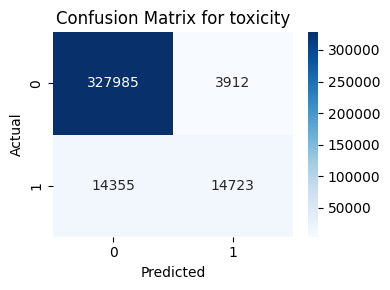

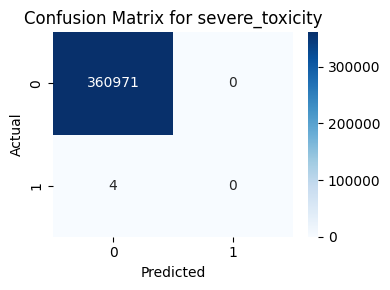

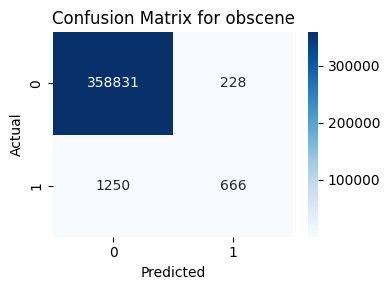

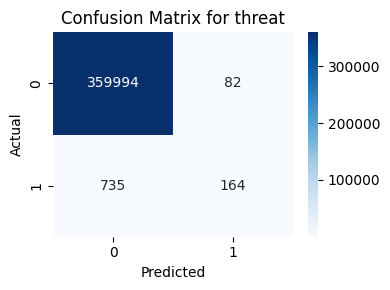

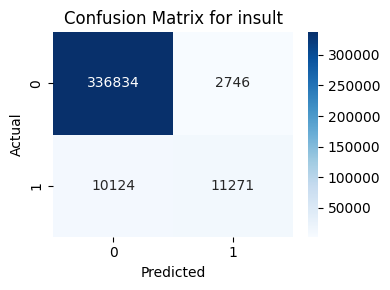

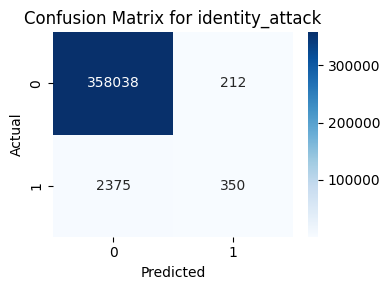

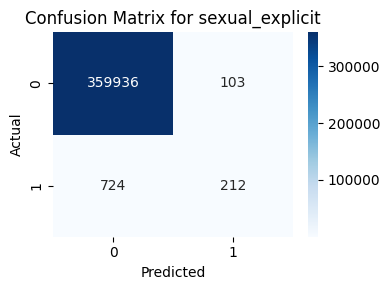

In [ ]:
#  Model predictions
y_pred_probs = model.predict(test_sequences)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Convert real values ​​to 0 or 1
test_labels = (test_labels >= 0.5).astype(int)

# Print classification report
print(classification_report(test_labels, y_pred, target_names=[
    'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'
], zero_division=0))

# confusion matrices
conf_matrix = multilabel_confusion_matrix(test_labels, y_pred)

# Draw a confusion matrix for each class
labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
for i, label in enumerate(labels):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [41]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   2.2.2
aiohappyeyeballs          2.4.4
aiohttp                   3.11.10
aiosignal                 1.2.0
anyio                     4.6.2
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 3.0.0
astunparse                1.6.3
async-lru                 2.0.4
attrs                     24.3.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
Bottleneck                1.4.2
Brotli                    1.0.9
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.3.1
cycler                    0.12.1
datasets                  3.3.2
debugpy                   1.8.11
decorator                 5.1.1
defusedxml                0.7.1
dill              